In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

device = 'cuda'

In [2]:
df = pd.read_csv("./data/emotions.csv")
df.head(), df.shape

(   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
 0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
 1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
 2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
 3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
 4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   
 
    mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
 0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
 1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
 2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
 3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
 4        3.06       41.40        5.52  ...       12.0       38.1       38.1   
 
    fft_744_b  fft_745_b

In [3]:
classes = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
def label_to_num(df):
    temp_df = df.copy()
    temp_df['label_num'] = temp_df['label'].map(classes)
    temp_df = temp_df.drop('label', axis=1)
    return temp_df
df2 = label_to_num(df)

In [5]:
device = 'cuda'

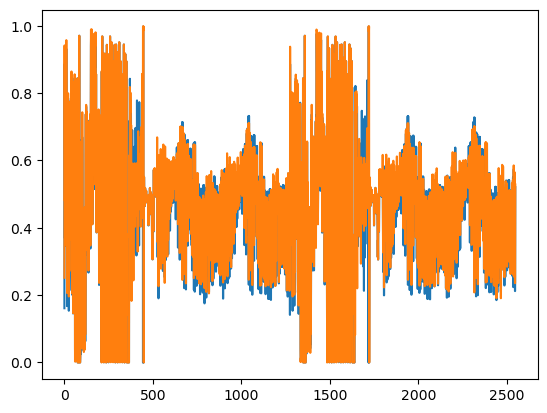

In [200]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os
import pandas as pd

df_raw = pd.read_csv("./data/emotions.csv")
df = label_to_num(df_raw)

X = df.drop('label_num', axis=1)
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plt.plot(X_train[0])
plt.plot(X_test[0])

# X_train[0][:5], X_test[0][:5], y_train.shape, y_test.shape

# features per input
INPUT_SIZE = 128

class EEGData(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y.to_numpy()).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        new_shape = math.ceil(X.shape[0] / INPUT_SIZE)
        padding = new_shape * INPUT_SIZE - X.shape[0]
        p = nn.ZeroPad1d((0,padding))
        X = p(X)

        X = X.reshape((new_shape, INPUT_SIZE))
        return X, y

train_dataset = EEGData(X_train, y_train)
test_dataset = EEGData(X_test, y_test)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size=128,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size=128,
                              shuffle=True)

In [236]:
from torch import nn

class LSTM_v0(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shape, lstm_layers):
        super().__init__()
        self.hidden_shape = hidden_shape
        self.lstm_layers = lstm_layers
        
        # N * 1 * L * in_shape
        # hidden shape = number of Long term memory values
        self.lstm = nn.LSTM(in_shape, hidden_shape, lstm_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, out_shape)
        )
    def forward(self, x):
        # number of LSTM layers * L * hidden shape
        h0 = torch.zeros(self.lstm_layers, 
                                x.size(0), 
                                self.hidden_shape).to(x.device)
        c0 = torch.zeros(self.lstm_layers, 
                                x.size(0), 
                                self.hidden_shape).to(x.device)
        # print(x.shape)
        x, (hn, cn) = self.lstm(x, (h0, c0))
        # print(f"{x.shape} | {hn.shape} | {cn.shape}")
        x = self.fc(x[:, -1, :])
        # print(x.shape)
        return x, (hn, cn)
    
IN_SHAPE = INPUT_SIZE
OUT_SHAPE = 3
HIDDEN_SHAPE = 128
LSTM_LAYERS = 1

model_0 = LSTM_v0(IN_SHAPE, OUT_SHAPE, HIDDEN_SHAPE, LSTM_LAYERS).to(device)
model_0

LSTM_v0(
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [237]:
h0_temp = None
c0_temp = None
idx, (temp_x, temp_y) = next(enumerate(train_dataloader))
with torch.inference_mode():
    result, (hn, cn) = model_0(temp_x.to(device))
result.softmax(dim=1)

tensor([[0.3388, 0.3556, 0.3056],
        [0.3388, 0.3555, 0.3057],
        [0.3388, 0.3555, 0.3056],
        [0.3385, 0.3558, 0.3057],
        [0.3388, 0.3556, 0.3056],
        [0.3389, 0.3555, 0.3056],
        [0.3387, 0.3553, 0.3060],
        [0.3386, 0.3556, 0.3058],
        [0.3387, 0.3556, 0.3057],
        [0.3387, 0.3555, 0.3057],
        [0.3386, 0.3555, 0.3059],
        [0.3386, 0.3557, 0.3058],
        [0.3387, 0.3554, 0.3059],
        [0.3388, 0.3556, 0.3056],
        [0.3387, 0.3553, 0.3059],
        [0.3384, 0.3555, 0.3061],
        [0.3387, 0.3556, 0.3057],
        [0.3388, 0.3556, 0.3056],
        [0.3389, 0.3555, 0.3056],
        [0.3389, 0.3556, 0.3056],
        [0.3384, 0.3557, 0.3059],
        [0.3391, 0.3553, 0.3056],
        [0.3388, 0.3555, 0.3056],
        [0.3389, 0.3553, 0.3057],
        [0.3389, 0.3555, 0.3057],
        [0.3388, 0.3556, 0.3056],
        [0.3387, 0.3556, 0.3058],
        [0.3384, 0.3557, 0.3060],
        [0.3387, 0.3556, 0.3057],
        [0.338

In [238]:
from torchmetrics import Accuracy, F1Score

optimizer = torch.optim.RMSprop(params = model_0.parameters(),
                            lr=0.0005,)
loss_fn = nn.CrossEntropyLoss().to(device)
acc_fn = Accuracy(task='multiclass', num_classes=3).to(device)
f1_fn = F1Score(task='multiclass', num_classes=3).to(device)

In [241]:
epochs = 100

for epoch in range(1, epochs):
    avg_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        model_0.train()        
        X, y = X.to(device), y.to(device)
    
        optimizer.zero_grad()
        logits, _ = model_0(X)
        loss = loss_fn(logits, y)
        avg_loss += loss
        loss.backward()
        optimizer.step()
    avg_loss = avg_loss / len(train_dataloader)

    model_0.eval()
    avg_acc = 0
    with torch.inference_mode():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            logits, _ = model_0(X)
            preds = logits.softmax(dim=1).argmax(dim=1)
            acc = acc_fn(preds, y)
            avg_acc += acc
        avg_acc = avg_acc / len(test_dataloader)

    print(f"Epoch: {epoch} | Train Loss: {avg_loss} | Test Acc: {avg_acc}")

Epoch: 1 | Train Loss: 0.18123005330562592 | Test Acc: 0.9102925062179565
Epoch: 2 | Train Loss: 0.17656010389328003 | Test Acc: 0.9045239686965942
Epoch: 3 | Train Loss: 0.17862258851528168 | Test Acc: 0.8790879249572754
Epoch: 4 | Train Loss: 0.18776340782642365 | Test Acc: 0.9046148061752319
Epoch: 5 | Train Loss: 0.1762867569923401 | Test Acc: 0.8752725124359131
Epoch: 6 | Train Loss: 0.17470374703407288 | Test Acc: 0.9259175062179565
Epoch: 7 | Train Loss: 0.16547241806983948 | Test Acc: 0.9278252124786377
Epoch: 8 | Train Loss: 0.1782686412334442 | Test Acc: 0.9200127124786377
Epoch: 9 | Train Loss: 0.17225250601768494 | Test Acc: 0.8792241811752319
Epoch: 10 | Train Loss: 0.16980773210525513 | Test Acc: 0.8693222999572754
Epoch: 11 | Train Loss: 0.1891699880361557 | Test Acc: 0.717387318611145
Epoch: 12 | Train Loss: 0.18338657915592194 | Test Acc: 0.8948491811752319
Epoch: 13 | Train Loss: 0.1576797515153885 | Test Acc: 0.9161518812179565
Epoch: 14 | Train Loss: 0.1610617190599

In [242]:
torch.save(model_0.state_dict(), "./models/LSTM_eeg.pth")

In [197]:
def train_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: torch.nn,
              acc_fn: Accuracy,
              f1_fn: F1Score,
              optimizer: torch.optim,
              device: str):
    model.train()
    # initialize metrics
    loss, acc = 0, 0

    for _, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        X, y = X.to(device), y.to(device)

        # forward pass
        logits, _ = model(X)
        preds = torch.round(logits).squeeze(dim=1)

        # print(f"{logits.squeeze(dim=1)}, {preds}")
        batch_loss = loss_fn(logits.squeeze(dim=1).double(), y)
        loss += batch_loss

        batch_acc = acc_fn(preds, y)
        acc += batch_acc

        # backpropagate + optimize
        batch_loss.backward()
        optimizer.step()

    return loss / len(dataloader), acc / len(dataloader)

In [244]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: torch.nn,
              acc_fn: Accuracy,
              f1_fn: F1Score,
              device: str):
    model.eval()
    loss, acc = 0, 0
    
    for i, (X, y) in enumerate(dataloader):
        with torch.inference_mode():
            X, y = X.to(device), y.to(device)

            logits, _ = model(X)
            preds = torch.round(logits).squeeze(dim=1)

            # print(f"{i}{logits}, {y}")
            batch_loss = loss_fn(logits, y)
            batch_acc = acc_fn(preds, y)

            loss += batch_loss
            acc += batch_acc
    return loss / len(dataloader), acc / len(dataloader)

h0_temp = None
c0_temp = None
test_step(model_0, test_dataloader, loss_fn, acc_fn, f1_fn, device)

(tensor(0.1700, device='cuda:0'), tensor(0.9590, device='cuda:0'))

In [199]:
epochs = 5

MODEL = model_0
TRAIN_DATALOADER = train_dataloader
TEST_DATALOADER = test_dataloader

# metric records
train_loss, test_loss = [], []
train_acc, test_acc = [], []
train_f1, test_f1 = [], []

for epoch in range(epochs):
    tr_loss, tr_acc = train_step(model=MODEL,
                                        dataloader=TRAIN_DATALOADER,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        f1_fn=f1_fn,
                                        optimizer=optimizer,
                                        device=device)
    train_loss.append(tr_loss.item())
    train_acc.append(tr_acc.item())

    te_loss, te_acc = test_step(model=MODEL,
                                       dataloader=TEST_DATALOADER,
                                       loss_fn=loss_fn,
                                       acc_fn=acc_fn,
                                       f1_fn=f1_fn,
                                       device=device)
    test_loss.append(te_loss.item())
    test_acc.append(te_acc.item())

    print(f"Epoch: {epoch} | Train Loss: {tr_loss} | Train Acc: {tr_acc} | Test Loss: {te_loss} | Test Acc: {te_acc}")

Epoch: 0 | Train Loss: 1.0990509006130948 | Train Acc: 0.32992538809776306 | Test Loss: 1.099901556968689 | Test Acc: 0.32771915197372437
Epoch: 1 | Train Loss: 1.0989962525934318 | Train Acc: 0.33140432834625244 | Test Loss: 1.1004045009613037 | Test Acc: 0.3405032753944397
Epoch: 2 | Train Loss: 1.0989367381569306 | Train Acc: 0.33288323879241943 | Test Loss: 1.1002757549285889 | Test Acc: 0.3362419009208679
Epoch: 3 | Train Loss: 1.0987614122132727 | Train Acc: 0.32992538809776306 | Test Loss: 1.1000118255615234 | Test Acc: 0.3447646200656891
Epoch: 4 | Train Loss: 1.0986289877463566 | Train Acc: 0.33140432834625244 | Test Loss: 1.0995501279830933 | Test Acc: 0.32771915197372437
